In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [3]:
# 1. Daten laden
file_path = "../data/processed/charging_sessions_cleaned.csv"
data = pd.read_csv(file_path, parse_dates=["connectionTime", "disconnectTime"])

# 2. Feature-Engineering
# Berechnung der durchschnittlichen Ladeleistung
data['averageChargingPower'] = data['kWhDelivered'] / ((data['disconnectTime'] - data['connectionTime']).dt.total_seconds() / 3600)
data['hourOfDay'] = data['connectionTime'].dt.hour  # Stunde des Tages aus connectionTime

# Berechnung der Standortauslastung
occupancy = []
for index, row in data.iterrows():
    count = data[(data['siteID'] == row['siteID']) &
                 (data['connectionTime'] <= row['disconnectTime']) &
                 (data['disconnectTime'] >= row['connectionTime'])].shape[0]
    occupancy.append(count)
data['siteOccupancy'] = occupancy

data = data.dropna(subset=['hourOfDay', 'averageChargingPower', 'siteID', 'siteOccupancy'])



Analyse für SiteID=1

Zielvariable: Charging Power
Mean Squared Error (MSE) für SiteID=1, Charging Power: 3.2838


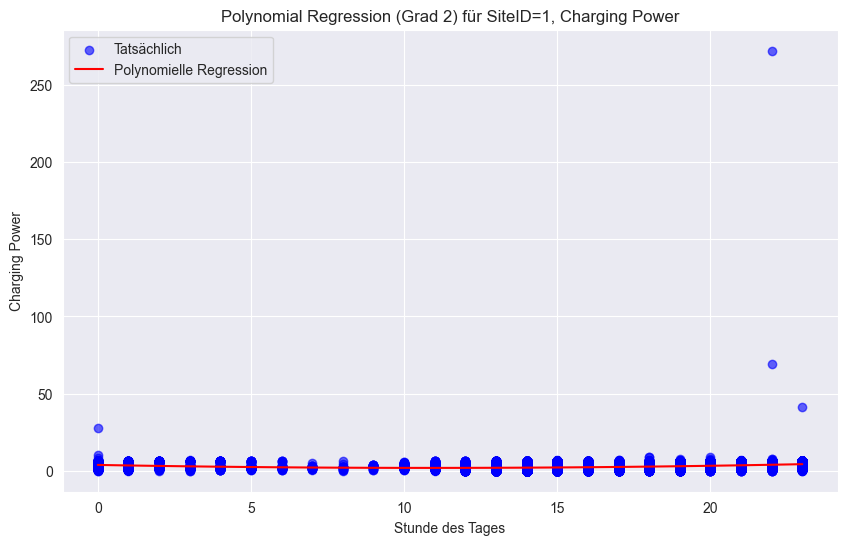


Zielvariable: Site Occupancy
Mean Squared Error (MSE) für SiteID=1, Site Occupancy: 792.4704


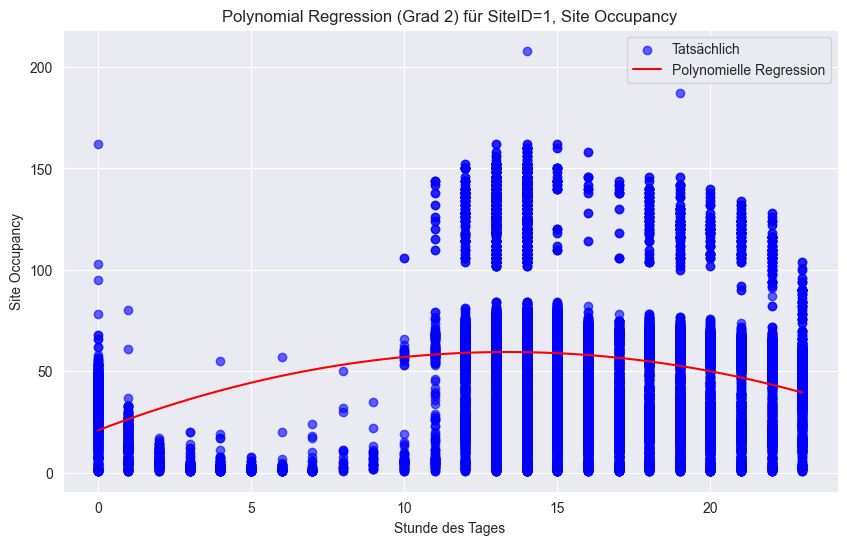


Analyse für SiteID=2

Zielvariable: Charging Power
Mean Squared Error (MSE) für SiteID=2, Charging Power: 31.5268


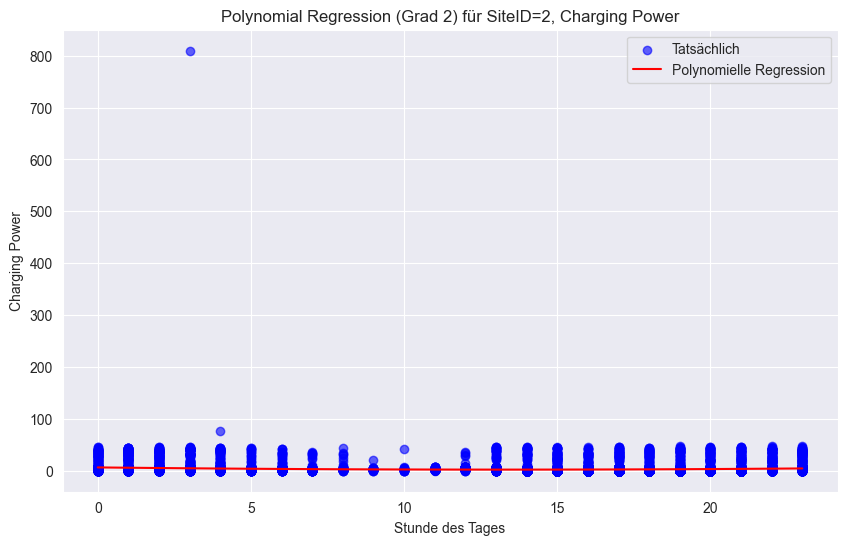


Zielvariable: Site Occupancy
Mean Squared Error (MSE) für SiteID=2, Site Occupancy: 402.4670


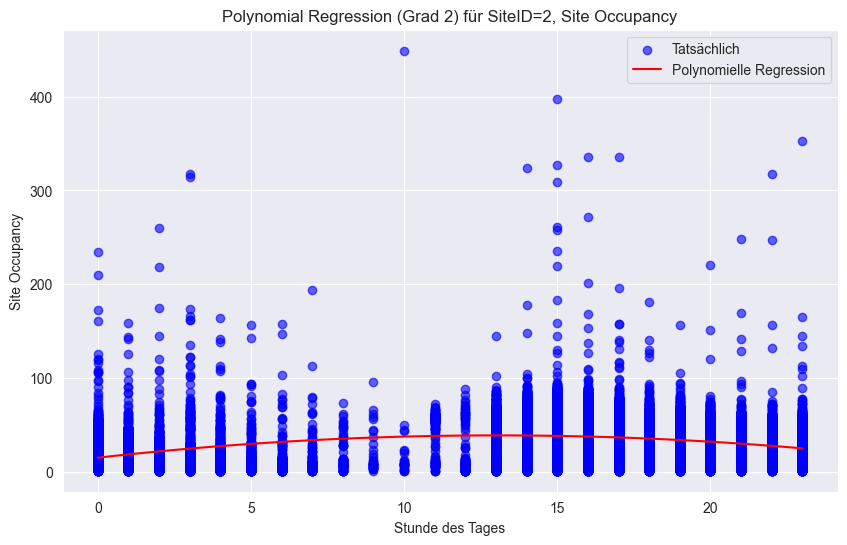

In [5]:
# Analyse für SiteID=1 und SiteID=2
for site in [1, 2]:
    print(f"\nAnalyse für SiteID={site}")
    site_data = data[data['siteID'] == site]

    for target, target_name in [("averageChargingPower", "Charging Power"), ("siteOccupancy", "Site Occupancy")]:
        print(f"\nZielvariable: {target_name}")

        # 3. Features und Zielvariable festlegen
        X = site_data[['hourOfDay']]
        y = site_data[target]

        # 4. Polynomial Features erstellen
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_poly = poly.fit_transform(X)

        # 5. Daten aufteilen
        X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

        # 6. Lineare Regression mit polynomiellen Features
        model = LinearRegression()
        model.fit(X_train, y_train)

        # 7. Vorhersagen und Fehler berechnen
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print(f"Mean Squared Error (MSE) für SiteID={site}, {target_name}: {mse:.4f}")

        # 8. Visualisierung der Ergebnisse
        plt.figure(figsize=(10, 6))
        plt.scatter(X['hourOfDay'], y, alpha=0.6, color="blue", label="Tatsächlich")

        # Für die Visualisierung: X_plot erstellen und transformieren
        X_plot = np.linspace(X['hourOfDay'].min(), X['hourOfDay'].max(), 100).reshape(-1, 1)
        X_plot_poly = poly.fit_transform(X_plot)  # Transform mit gleichen PolynomialFeatures

        y_plot = model.predict(X_plot_poly)
        plt.plot(X_plot, y_plot, color="red", label="Polynomielle Regression")
        plt.xlabel("Stunde des Tages")
        plt.ylabel(target_name)
        plt.title(f"Polynomial Regression (Grad 2) für SiteID={site}, {target_name}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Ergebnisse speichern
        results = pd.DataFrame({"HourOfDay": X_test[:, 0], "Actual": y_test, "Predicted": y_pred})
        results.to_csv(f"polynomial_regression_results_site{site}_{target_name.lower().replace(' ', '_')}.csv", index=False)
